In [1]:
from __future__ import division
import simpy
import random
import statistics
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt


In [9]:
def load_market_data():
    for i in range(2, 20):
        df = pd.DataFrame()
        if(i>9):
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_20'+str(i)+'.csv', skiprows=3))
        else: 
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_200'+str(i)+'.csv', skiprows=3))
        df = clean_market_data(df)
    return df

def clean_market_data(df):
    try:
        df['HOEP'] = pd.to_numeric(df['HOEP'].str.replace(',', ''))
    except:
        print("Already Number")
    return df

def load_data():
    ampds = DataSet("./data/load_profile/AMPds2.h5")
    dataset = {}
    nam_map = {}
    elec = ampds.buildings[1].elec
    for item in range(1,20):
        appl = elec.meters.__getitem__(item)
        name = appl.appliances[0].metadata.get('original_name')
        arr = []
        for g in appl.load():
            arr.append(g)
        df = pd.DataFrame(arr[0])
        df.columns = [ 'pf_ap', 'reactive', 'apparent', 'active']
        dataset[name]= df
        dataset[name+"_INFO"] = elec.meters.__getitem__(item).appliances[0].metadata
    return dataset

def weather_data():
    climate = pd.read_csv('./data/load_profile/Climate_HourlyWeather.csv')
    drop = ['Data Quality', 'Temp Flag', 'Dew Point Temp Flag', 'Wind Spd Flag', 'Stn Press Flag',
          'Hmdx Flag', 'Wind Chill Flag', 'Wind Dir Flag', 'Rel Hum Flag', 'Visibility Flag']
    climate = climate.drop(columns = drop, axis=1)
    return climate





In [3]:
def get_rands_from_data(inputdata, num):

    print(inputdata)
    data = inputdata.fillna(0)
    hist, bins = np.histogram(data, bins=50)

    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]

    plt.subplot(121)
    plt.hist(data, 50)
    plt.subplot(122)
    plt.hist(random_from_cdf, 50)
    plt.show()
    print(random_from_cdf)

0        28.0
1        17.0
2        26.0
3        39.0
4        30.0
         ... 
17515    21.0
17516    14.0
17517     7.0
17518    10.0
17519     4.0
Name: Wind Spd (km/h), Length: 17520, dtype: float64


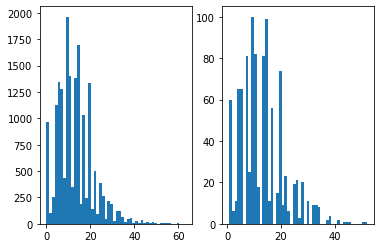

[19.53 10.71 13.23 18.27  5.67 17.01  9.45 25.83 19.53 19.53 22.05  6.93
  3.15 23.31 14.49 10.71  0.63 13.23  0.63 17.01 22.05  9.45 13.23 20.79
 11.97  4.41  4.41  0.63  5.67 38.43 14.49 22.05 10.71 19.53 34.65 24.57
  5.67  5.67 11.97 13.23  0.63  5.67  4.41  6.93 11.97  6.93 10.71 14.49
  5.67 29.61 17.01 13.23 13.23  9.45 14.49 29.61  6.93 19.53  9.45  5.67
 19.53 17.01  9.45  9.45  9.45 22.05  9.45  6.93 29.61 19.53  6.93  6.93
 32.13  4.41  6.93 23.31 13.23 27.09 25.83  1.89  5.67 13.23 13.23  5.67
 25.83  9.45  9.45 19.53 19.53  8.19  5.67 14.49  0.63 28.35  4.41 28.35
  5.67  0.63 19.53 17.01 14.49  6.93  5.67 24.57 13.23 24.57  4.41  1.89
 19.53  0.63 14.49  9.45  9.45  6.93  9.45  0.63 19.53 13.23 13.23  0.63
 14.49  6.93 24.57  5.67  4.41  9.45 17.01 24.57  1.89 24.57 10.71 13.23
 13.23 33.39  4.41  9.45 13.23 10.71 17.01  9.45  4.41 10.71 14.49  9.45
  0.63  9.45 19.53 10.71 17.01 29.61 17.01 17.01  4.41  6.93 14.49 17.01
 19.53 24.57 11.97 14.49 22.05  9.45  8.19 17.01  8

In [30]:
test = weather_data()
get_rands_from_data( test["Wind Spd (km/h)"], 1000)

In [4]:
house_params = {
    #power_consumption parameters
    'television_power' : 10,
    'microwave_power' : 4,
    'air_condition_power' :30,
    'fridge_power' : 14,
    'heat_pump_power' : 20,

    #state variables, not sure abt water temp
    'water_temp' : 30,
    'water_target' : 40,
    'home_temp': 28,
    'target_temp' : 27,
    'fridge_temp' : 10,
    'fridge_target' : 5,

}
with open('house_params.json', 'w') as fp:
    json.dump(house_params, fp)

In [5]:
params = json.load(open(('house_params.json')))
params

{'television_power': 10,
 'microwave_power': 4,
 'air_condition_power': 30,
 'fridge_power': 14,
 'heat_pump_power': 20,
 'water_temp': 30,
 'water_target': 40,
 'home_temp': 28,
 'target_temp': 27,
 'fridge_temp': 10,
 'fridge_target': 5}

In [6]:
class Meter(object):

    load_distros = []
    load_infos = []
    #consumption of power by appliances on time step
    lights = 0
    
    #power_consumption parameters
    television_power = 10
    microwave_power = 4
    air_condition_power = 30
    fridge_power = 14
    heat_pump_power = 20
    
    #state variables, not sure abt water temp
    water_temp = 30
    water_target = 40
    home_temp = 28
    target_temp = 27
    fridge_temp = 10
    fridge_target = 5
    
    #set up as the duration left that appliance n is running, 0 means it is off
    microwave= 0
    television = 4

    net_load = 0
    power_thresh = 200
    
    def __init__(self, json_path):
        params = json.load(open(json_path))
        print(str(params))
        try:
            
            #power_consumption parameters
            self.television_power = params['television_power']
            self.microwave_power = params['microwave_power']
            self.air_condition_power = params['air_condition_power']
            self.fridge_power = params['fridge_power']
            self.heat_pump_power = params['heat_pump_power']

            #state variables, not sure abt water temp
            self.water_temp = params['water_temp']
            self.water_target = params['water_target']
            self.home_temp = params['home_temp']
            self.target_temp = params['target_temp']
            self.fridge_temp = params['fridge_temp']
            self.fridge_target = params['fridge_target']
        except:
            print("some or all parameters are missing")

In [13]:
class House(object):
    
    #switch control for AC
    air_condition = False
    fridge = True
    heat_pump = True
    
    meter = Meter('house_params.json')
    
    
    def __init__(self, env, json_path):
        self.env = env
        params = json.load(open(json_path))
        print(str(params))
        self.meter.meter = Meter(json_path)
            

    def get_event_power(self):

            if self.meter.television != 0:
                #print("TELEVISION "+str(self.meter.television))
                self.meter.television=self.meter.television-1
            #this should be modified to match actual probability distribution
            elif random.randint(1, 20)>19:
                #TODO w prob distribution
                self.meter.television = random.randint(300, 7200)
                print("tv turned on for "+ str(self.meter.television/60)+ " minutes")
            if self.meter.microwave!=0:
                self.meter.microwave-=1
            elif random.randint(1, 5)>4:
                #TODO w prob distribution
                self.meter.microwave = random.randint(30, 500)
                #print("microwave turned on for "+ str(self.meter.microwave/60)+ " minutes")

            return self.meter.television_power+self.meter.microwave_power

    def get_reccuring_power(self):

        load = 0
        if self.air_condition:
            load+= self.meter.air_condition_power
            self.meter.home_temp-=0.0025
            if self.meter.home_temp<self.meter.target_temp:
                self.air_condition = False
        else:
            if self.meter.home_temp>self.meter.target_temp:  
                #print("ac turned on")
                self.air_condition = True
            self.meter.home_temp+=0.0045
            #TODO w prob distribution

            #print("AC turned on")
        if self.fridge:
            load+= self.meter.fridge_power
            self.meter.fridge_temp-=0.0025
            if self.meter.fridge_temp<self.meter.fridge_temp:
                self.fridge = False
        else:
            if self.meter.fridge_temp>self.meter.fridge_target:  
                self.fridge = True
            self.meter.fridge_temp+=0.0045
            #TODO w prob distribution

            #print("Fridge turned on")
        if self.heat_pump:
            load+= self.meter.heat_pump_power
            self.meter.water_temp+=0.025
            if self.meter.water_temp>self.meter.water_target:
                self.heat_pump = False
        else:
            if self.meter.fridge_temp>self.meter.fridge_target:  
                self.heat_pump = True
            self.meter.water_temp-=0.025
            #TODO w prob distribution

            #print("Heat Pump turned on")

        return load

    def get_light_power(self):
        #needs to be matched to lights prob distribution given time of day

        self.meter.lights = random.randint(10, 20)
        return self.meter.lights

    def run_load(self):
        #print("Next")
        self.meter.net_load = 0
        self.meter.net_load+=self.get_event_power()
        self.meter.net_load+=self.get_reccuring_power()
        self.meter.net_load+=self.get_light_power()
        #print("LOAD IS"+str(self.meter.net_load))
        return self.meter.net_load


    


{'television_power': 10, 'microwave_power': 4, 'air_condition_power': 30, 'fridge_power': 14, 'heat_pump_power': 20, 'water_temp': 30, 'water_target': 40, 'home_temp': 28, 'target_temp': 27, 'fridge_temp': 10, 'fridge_target': 5}


In [14]:
total_load =  0
timestep = 0
ren_power = 0
#replace with probabilistic model sampling
energy_price = 1
total_cost = 0



        
def run_grid_loads(env, loads):

    global total_load
    total_load= 0
    
    for l in loads:
        total_load+=l.run_load()
    
    return total_load


def run_simulation(env, num_houses, renewable_sources, num_batteries):
    global timestep
    houses = []
    for i in range(0, num_houses):
        houses.append(House(env, 'house_params.json'))

    while True:
        yield env.timeout(1)  # Wait a bit before generating a new person
        timestep += 1
        run_grid_loads(env, houses)
        #print(get_power(renewable_sources))



def get_power(rens):
    global ren_power
    global total_cost
    ren_power = 0
    #would likely get renewables probabilistic cost at this time
    for i in range(0, rens):
        ren_power+=random.randint(220, 290)
    
    if total_load<=ren_power:
        total_cost -= (ren_power-total_load)*energy_price
    else:
        total_cost -= (ren_power-total_load)*energy_price
    
    return total_cost

def main():
    # Setup
    random.seed(42)

    # Run the simulation
    env = simpy.Environment()
    env.process(run_simulation(env, 10, 4, 1))
    #Seconds to run the simulation
    env.run(until=86400)


if __name__ == '__main__':
    main()

{'television_power': 10, 'microwave_power': 4, 'air_condition_power': 30, 'fridge_power': 14, 'heat_pump_power': 20, 'water_temp': 30, 'water_target': 40, 'home_temp': 28, 'target_temp': 27, 'fridge_temp': 10, 'fridge_target': 5}
{'television_power': 10, 'microwave_power': 4, 'air_condition_power': 30, 'fridge_power': 14, 'heat_pump_power': 20, 'water_temp': 30, 'water_target': 40, 'home_temp': 28, 'target_temp': 27, 'fridge_temp': 10, 'fridge_target': 5}
{'television_power': 10, 'microwave_power': 4, 'air_condition_power': 30, 'fridge_power': 14, 'heat_pump_power': 20, 'water_temp': 30, 'water_target': 40, 'home_temp': 28, 'target_temp': 27, 'fridge_temp': 10, 'fridge_target': 5}
{'television_power': 10, 'microwave_power': 4, 'air_condition_power': 30, 'fridge_power': 14, 'heat_pump_power': 20, 'water_temp': 30, 'water_target': 40, 'home_temp': 28, 'target_temp': 27, 'fridge_temp': 10, 'fridge_target': 5}
{'television_power': 10, 'microwave_power': 4, 'air_condition_power': 30, 'fridg

tv turned on for 30.15 minutes
tv turned on for 113.66666666666667 minutes
tv turned on for 105.53333333333333 minutes
tv turned on for 15.283333333333333 minutes
tv turned on for 112.81666666666666 minutes
tv turned on for 100.73333333333333 minutes
tv turned on for 86.91666666666667 minutes
tv turned on for 94.76666666666667 minutes
tv turned on for 18.15 minutes
tv turned on for 20.75 minutes
tv turned on for 90.56666666666666 minutes
tv turned on for 7.783333333333333 minutes
tv turned on for 43.766666666666666 minutes
tv turned on for 82.61666666666666 minutes
tv turned on for 87.71666666666667 minutes
tv turned on for 83.93333333333334 minutes
tv turned on for 46.95 minutes
tv turned on for 99.6 minutes
tv turned on for 91.81666666666666 minutes
tv turned on for 35.96666666666667 minutes
tv turned on for 91.3 minutes
tv turned on for 101.11666666666666 minutes
tv turned on for 13.75 minutes
tv turned on for 75.43333333333334 minutes
tv turned on for 39.56666666666667 minutes
tv t

In [4]:
#Measurements / Observations
# 
'''
1 week of simulation with 10 loads takes roughly 22-23 seconds on my computer
1 day with 10 loads takes roughly 3 seconds

With the current buy / sell model (no battery) the price either skews to the left 
or the right, so it's a bit tougher to make highly consistent

AC stays almost consistently on to maintain exact temperature, but if pushed to degree
or a smaller precision power / ac time can be saved significantly

Load modelling seems to be relatively functional. Controls will be maintained for only 
sections of the load modelling, such as AC, Heat Pump, and Fridge
    - based on the AMPdS dataset these are actually a substantial portion of the load
    
Tweaking seemingly does a lot to save on loads

''' 

"\n1 week of simulation with 10 loads takes roughly 22-23 seconds on my computer\n1 day with 10 loads takes roughly 3 seconds\n\nWith the current buy / sell model (no battery) the price either skews to the left \nor the right, so it's a bit tougher to make highly consistent\n\nAC stays almost consistently on to maintain exact temperature, but if pushed to degree\nor a smaller precision power / ac time can be saved significantly\n\nLoad modelling seems to be relatively functional. Controls will be maintained for only \nsections of the load modelling, such as AC, Heat Pump, and Fridge\n    - based on the AMPdS dataset these are actually a substantial portion of the load\n    \nTweaking seemingly does a lot to save on loads\n\n"

In [27]:
timestep = 1001
market_params = {}
weather_params = {}

weather_predictions = []
market_predictions = []
weather_pred_depth = 10
market_pred_depth = 24

def update_weather():
    weather = weather_data()
    weather_params = weather.iloc[timestep]

    weather_predictions = weather.iloc[timestep:timestep+weather_pred_depth]
    print(weather_params)
    
#performed every hour
def update_price():
    market = load_market_data()
    market_params = market.iloc[timestep]
    market_predictions = weather.iloc[timestep:timestep+market_pred_depth]
    print(market_params)

In [28]:
update_weather()

Date/Time             2012-05-12 17:00
Year                              2012
Month                                5
Day                                 12
Time                             17:00
Temp (C)                          17.5
Dew Point Temp (C)                 6.7
Rel Hum (%)                         49
Wind Dir (10s deg)                  31
Wind Spd (km/h)                     13
Visibility (km)                   48.3
Stn Press (kPa)                  102.1
Hmdx                               NaN
Wind Chill                         NaN
Weather                          Clear
Name: 1001, dtype: object
